In [2]:
%load_ext autoreload
%autoreload 2

In [72]:
import pandas as pd
import seaborn as sns
import numpy as np

# resid_df = pd.read_csv('/Users/josh/Documents/Harvard/GLM/sabatinilab-glm/sglm/outputs/fig1/all/full-run_0-ft/reports/residuals/best_resids/63_64_65_66_67_68_69_57_58_59_60_61_53_55_56_best_resids_R2_0.1986_all.csv')
resid_df = pd.read_csv('/Users/josh/Documents/Harvard/GLM/sabatinilab-glm/sglm/outputs/fig1/all/only-all_0-ft/reports/residuals/best_resids/63_64_65_66_67_68_69_57_58_59_60_61_53_55_56_best_resids_R2_0.2127_all.csv')
resid_df = resid_df[~resid_df['dupe']]
def get_triplicated_data_for_time_alignment(df, alignment_col):
    """

    """

    rel_points = df[df[alignment_col] > 0].reset_index()
    identifiers = rel_points[['index', 'nTrial', 'nEndTrial']].dropna().values.astype(int)
    if len(identifiers) == 0:
        return pd.DataFrame(columns=df.reset_index().columns)

    lst_extendeds = []
    
    for idx, nTrial, nEndTrial in identifiers:
        extended_trial = df[(df['nTrial'] == nTrial) | (df['nEndTrial'] == nEndTrial)].reset_index().copy()
        extended_trial = extended_trial[(extended_trial['nTrial'] - extended_trial['nEndTrial']) == extended_trial['diffTrialNums']]
        extended_trial['index'] -= idx

        lst_extendeds.append(extended_trial.copy())
        
    relative_df = pd.concat(lst_extendeds)
    return relative_df

def plot_single_avg_reconstruction_v2(df, alignment_col, channel,
                                      title=None, trial_num=None, x_label=None, y_label=None,
                                      inx_bounds=(-40, 60), signal_bounds=(-1, 2.5),
                                      ic=None, color_lst=['b', 'g', 'y', 'k'],
                                      fig=None, ax=None, show_pred=True):
    """
    
    """

    color = color_lst[ic]
    
    relative_df = get_triplicated_data_for_time_alignment(df, alignment_col)

    df_filt_to_bounds = relative_df[relative_df['index'].between(*inx_bounds)].copy()
    df_filt_to_bounds['resids'] = df_filt_to_bounds[channel] - df_filt_to_bounds['pred']
    num_trials = (df_filt_to_bounds['index'] == 0).sum()

    rmse = np.sqrt((df_filt_to_bounds['resids']**2).mean())

    alignment_name = alignment_col.split('_')[-1]
    sns.lineplot(x='index', y=channel, data=df_filt_to_bounds, label=f'{alignment_col} — {channel} — True', ax=ax, color=color)
    if show_pred:
        sns.lineplot(x='index', y='pred', data=df_filt_to_bounds, label=f'{alignment_col} — {channel} — Pred', ax=ax, color='r')
    
    ax.title.set_text(f'{title} — {num_trials} Trials — RMSE: {rmse:.2f}')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    ax.set_ylim(*signal_bounds)
    ax.grid(visible=True)
    
    return


In [98]:
b0 = np.arange(len(resid_df))
display(b0)

rdc = []

lb = -40
ub = 100
for event_col in ['photometrySideInIndexr']:
    resid_df_cutdown = resid_df[['Unnamed: 0', 'file_num', 'nTrial', 'nEndTrial', 'wi_trial_keep',
                                 'gDA', 'gACH', 'rDA', event_col, 'pred_paramsNum=0_gACH']].copy()

    event = np.where(resid_df_cutdown[event_col].values == 1)[0]
    print(b0.shape, event.shape)
    for iev, ev in enumerate(event):
        delta = b0 - ev
        # print(delta)
        keep_eg = (delta >= -40)&(delta <= 100)
        delta_keep_eg = delta[keep_eg]
        rdf_tmp = resid_df_cutdown.loc[keep_eg].copy()
        rdf_tmp['delta'] = delta_keep_eg
        # display(rdf_tmp)
        # display(list(rdf_tmp.columns))
        rdc.append(rdf_tmp)
        if iev > 10000:
            break
    break

rdc_df = pd.concat(rdc)#.groupby('delta').agg([np.mean, np.std, np.size])

array([      0,       1,       2, ..., 1992474, 1992475, 1992476])

(1992477,) (13011,)


In [99]:
seed = np.random.randint(1000000000)

/Users/josh/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/josh/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='delta', ylabel='gACH'>

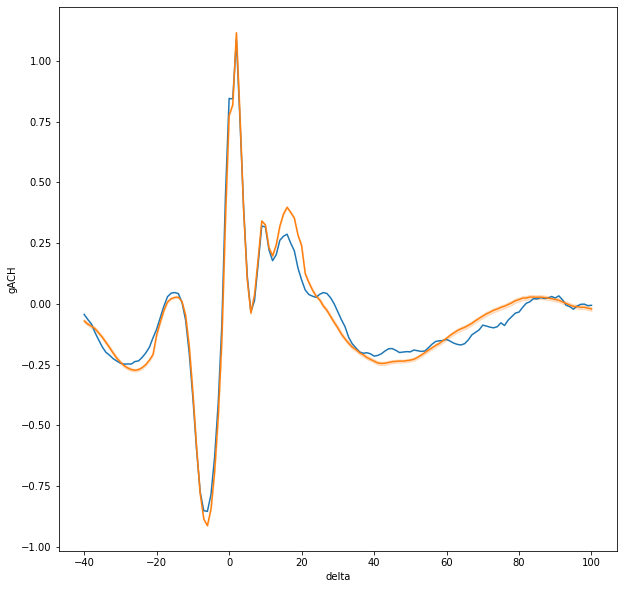

In [100]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1,figsize=(10,10))
sns.lineplot(rdc_df['delta'], rdc_df['gACH'], seed=seed, ax=ax)
sns.lineplot(rdc_df['delta'], rdc_df['pred_paramsNum=0_gACH'], seed=seed, ax=ax)

In [101]:
# rdc_df.columns = ['_'.join(_) for _ in rdc_df.columns]
# rdc_df
# col_to_use = 'gACH'
# pred_col_to_use = f'pred_paramsNum=0_{col_to_use}'

# rdc_df[f'lb_{col_to_use}'] = rdc_df[f'{col_to_use}_mean'] - 2*rdc_df[f'{col_to_use}_std']/np.sqrt(rdc_df[f'{col_to_use}_size'])
# rdc_df[f'ub_{col_to_use}'] = rdc_df[f'{col_to_use}_mean'] + 2*rdc_df[f'{col_to_use}_std']/np.sqrt(rdc_df[f'{col_to_use}_size'])

# rdc_df[f'lb_{pred_col_to_use}'] = rdc_df[f'{pred_col_to_use}_mean'] - 2*rdc_df[f'{pred_col_to_use}_std']/np.sqrt(rdc_df[f'{pred_col_to_use}_size'])
# rdc_df[f'ub_{pred_col_to_use}'] = rdc_df[f'{pred_col_to_use}_mean'] + 2*rdc_df[f'{pred_col_to_use}_std']/np.sqrt(rdc_df[f'{pred_col_to_use}_size'])

# # display(rdc_df['gDA_mean'] - 2*rdc_df['gDA_std']/np.sqrt(rdc_df['gDA_size']))
# # display(rdc_df['gDA_mean'] + 2*rdc_df['gDA_std']/np.sqrt(rdc_df['gDA_size']))

# # display(rdc_df['gDA_mean'] - 2*rdc_df['gDA_std']/np.sqrt(rdc_df['gDA_size']))
# # display(rdc_df['gDA_mean'] + 2*rdc_df['gDA_std']/np.sqrt(rdc_df['gDA_size']))

# rdc_df[[f'lb_{col_to_use}', f'{col_to_use}_mean', f'ub_{col_to_use}',
#         f'lb_{pred_col_to_use}', f'{pred_col_to_use}_mean', f'ub_{pred_col_to_use}', 
#         ]].plot()


In [137]:
import glob

coef_dfs = []
for run_file in glob.glob('/Users/josh/Documents/Harvard/GLM/sabatinilab-glm/sglm/outputs/fig1/all/only-all-10x-te_0-ft/reports/coeffs/best_coeffs/*'):
    coef_dfs.append(pd.read_csv(run_file))

concat = pd.concat(coef_dfs)

name
base-simple    AxesSubplot(0.125,0.125;0.775x0.755)
no-CI          AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

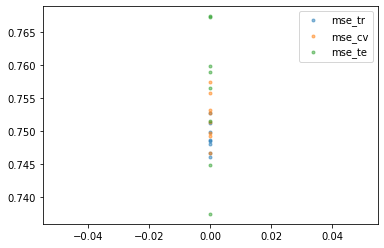

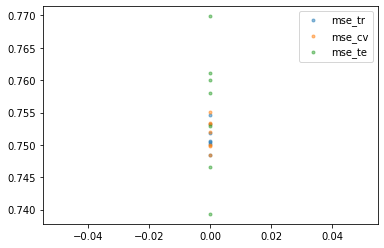

In [138]:
# coef_ci = concat.sort_values('channel_name').groupby('name')[
#     ['mse_tr', 'mse_cv', 'mse_te', 
#     #'r2_tr', 'r2_cv', 'r2_te'
#     ]
# ].agg([np.min, np.max, np.mean, #np.std, np.size
#     ])
# coef_ci.columns = ['_'.join(_) for _ in coef_ci.columns]
concat.groupby('name')[['mse_tr', 'mse_cv', 'mse_te']].plot(marker='.', linestyle='', alpha=0.5)

In [156]:
concat2 = concat.copy()
concat2['mse_dif'] = (concat2['mse_tr'] <= concat2['mse_te'])
concat2['mse_del'] = (concat2['mse_te'] - concat2['mse_tr'])
concat2['r2_dif'] = (concat2['r2_tr'] > concat2['r2_te'])
concat2['r2_del'] = (concat2['r2_tr'] - concat2['r2_te'])
concat2_out = np.round(concat2.groupby('name')[['mse_dif', 'r2_dif']].agg([np.sum, np.size, np.mean]), 4)
display(concat2_out)
concat2_out = np.round(concat2.groupby('name')[['mse_del', 'r2_del']].agg([np.mean, np.max, np.min]), 4)
display(concat2_out)

mse_dif              r2_dif             
                sum size    mean    sum size    mean
name                                                
base-simple       6    8  0.7500      6    8  0.7500
no-CI             5    7  0.7143      5    7  0.7143

mse_del                  r2_del                
               mean    amax    amin    mean    amax    amin
name                                                       
base-simple  0.0065  0.0211 -0.0152  0.0070  0.0183 -0.0138
no-CI        0.0041  0.0214 -0.0152  0.0074  0.0183 -0.0141

In [102]:
# delta